# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
Data is read from prefabricated files containing the Sun and the two Satellites' positions as time series. The data is stored and read in the HDF5 format.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  os, sys

import  numpy as np
import  yaml
import  matplotlib.pyplot as plt
import  simpy

sys.path.append('../')  # Add parent dir to path

# ---------------------------------------------------------
import  lusee        # Core lusee software
import  nav          # Astro/observation wrapper classes
from    nav import *
from    utils.timeconv import *

import  sim          # Main simulation handler
from    sim import Simulator

print("---------------------------------- PATH ----------------------------------------")
for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')



print('--------------------------------- VERSIONS -------------------------------------')
print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

# Define paths in one place:
orbitals    = "../data/20260110-20270115.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"

#comtable    = "../config/comtable-20260110-20270115.yml"
#comtable    = "./simulator_log.yml"
comtable = None

initial_time=2
until=4000
#2780

smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)

mjd_start   = smltr.sun.mjd[initial_time]
mjd_end     = smltr.sun.mjd[until]

print(f'''Initial time in ticks: {initial_time}, mjd: {mjd_start}, datetime: {mjd2dt(mjd_start)}, Sun Alt: {smltr.sun.alt[initial_time]}''')
print(f'''Until time in ticks: {until}, mjd: {mjd_end}, datetime: {mjd2dt(mjd_end)}''')

print(smltr.schedule)

# OPTIONAL
# smltr.info()

---------------------------------- PATH ----------------------------------------
/home/anze/Dropbox/work/lusee/opsim/notebooks
/home/anze
/user/luseepy
/user/refspec/cppyy
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/home/anze/snap/docker/2904/.local/lib/python3.10/site-packages
/usr/local/lib/python3.10/site-packages
../
--------------------------------- VERSIONS -------------------------------------
simpy: 4.1.1, lusee: 1.0, sim: 0.1
Shape of the data payload: (35450, 7)
Created a Battery with initial charge: 385714.2857142857, capacity: 879428.5714285714
Created a SSD with initial fill: 0.0, capacity: 32000000.0
Adding panel EPanel with normal [1. 0. 0.] and efficiency 1.0
Adding panel WPanel with normal [-1.  0.  0.] and efficiency 1.0
Adding panel TPanel with normal [0. 0. 1.] and efficiency 1.0
Initial time in ticks: 2, mjd: 61050.854166666664, datetime: 2026-01-10 20:30:00, Sun Alt: -0.002816656479612557
Until time in ticks: 4000,

---

### Run the simulation

In [2]:
# Set verbose if needed:
smltr.verbose = True
smltr.simulate(create_command_table=True)
comtable = './command_table.yml'
smltr.save_record(comtable)


Clock:61050.854166666664, mode: science
Device states: {'spectrometer': 'ON', 'comms': 'OFF', 'bms': 'OFF', 'pfps': 'ON', 'dcb': 'ON'}
Device:bms,            	state:OFF,\power:0.0
Device:spectrometer,   	state:ON,\power:12
Device:comms,          	state:OFF,\power:0.0
Device:pfps,           	state:ON,\power:6.1
Device:dcb,            	state:ON,\power:2.0
*** Total power load: 20.1 W
Clock:61054.833333333336, mode: comms
Device states: {'spectrometer': 'OFF', 'comms': 'ON', 'bms': 'ON', 'pfps': 'ON', 'dcb': 'ON'}
Device:bms,            	state:ON,\power:1.0
Device:spectrometer,   	state:OFF,\power:0.0
Device:comms,          	state:ON,\power:0.1
Device:pfps,           	state:ON,\power:6.1
Device:dcb,            	state:ON,\power:2.0
*** Total power load: 9.2 W
Clock:61054.864583333336, mode: science
Device states: {'spectrometer': 'ON', 'comms': 'OFF', 'bms': 'OFF', 'pfps': 'ON', 'dcb': 'ON'}
Device:bms,            	state:OFF,\power:0.0
Device:spectrometer,   	state:ON,\power:12
Device:comm

In [3]:
## now run again with generated command table
comtable = './command_table.yml'
smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)
smltr.verbose = True
smltr.simulate()

Shape of the data payload: (35450, 7)
Created a Battery with initial charge: 385714.2857142857, capacity: 879428.5714285714
Created a SSD with initial fill: 0.0, capacity: 32000000.0
Adding panel EPanel with normal [1. 0. 0.] and efficiency 1.0
Adding panel WPanel with normal [-1.  0.  0.] and efficiency 1.0
Adding panel TPanel with normal [0. 0. 1.] and efficiency 1.0
Clock:61050.854166666664, mode: science
Device states: {'spectrometer': 'ON', 'comms': 'OFF', 'bms': 'OFF', 'pfps': 'ON', 'dcb': 'ON'}
Device:bms,            	state:OFF,\power:0.0
Device:spectrometer,   	state:ON,\power:12
Device:comms,          	state:OFF,\power:0.0
Device:pfps,           	state:ON,\power:6.1
Device:dcb,            	state:ON,\power:2.0
*** Total power load: 20.1 W
Clock:61054.833333333336, mode: comms
Device states: {'spectrometer': 'OFF', 'comms': 'ON', 'bms': 'ON', 'pfps': 'ON', 'dcb': 'ON'}
Device:bms,            	state:ON,\power:1.0
Device:spectrometer,   	state:OFF,\power:0.0
Device:comms,         

---

### Plot the results

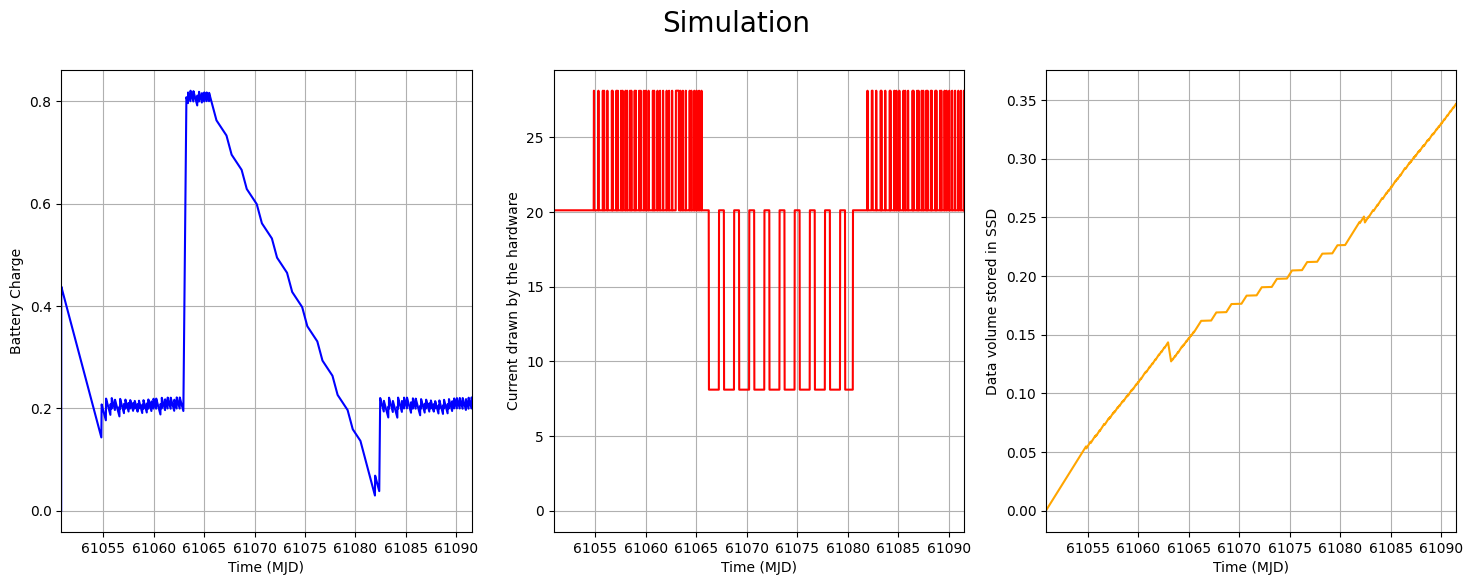

In [4]:
fig, (p1, p2, p3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [18., 6.]
# plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p1.set_ylabel('Battery Charge')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('Current drawn by the hardware')

p3.set_xlabel('Time (MJD)')
p3.set_ylabel('Data volume stored in SSD')

mjd = smltr.sun.mjd
p1.plot(mjd, smltr.monitor.battery, color="blue",   label="Battery")
p2.plot(mjd, smltr.monitor.power, color="red",    label="Power drawn")
p3.plot(mjd, smltr.monitor.ssd,     color="orange", label="SSD")

xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until] - 1

p1.set_xlim([xlo, xhi])
p2.set_xlim([xlo, xhi])
p3.set_xlim([xlo, xhi])

p1.grid(True)
p2.grid(True)
p3.grid(True)

plt.show()





In [5]:
# Keep a cell for debugging:
# for c in smltr.monitor.current:
#    print(c)

---

### Optional -- some graphs.



35450


(61110.0, 61114.0)

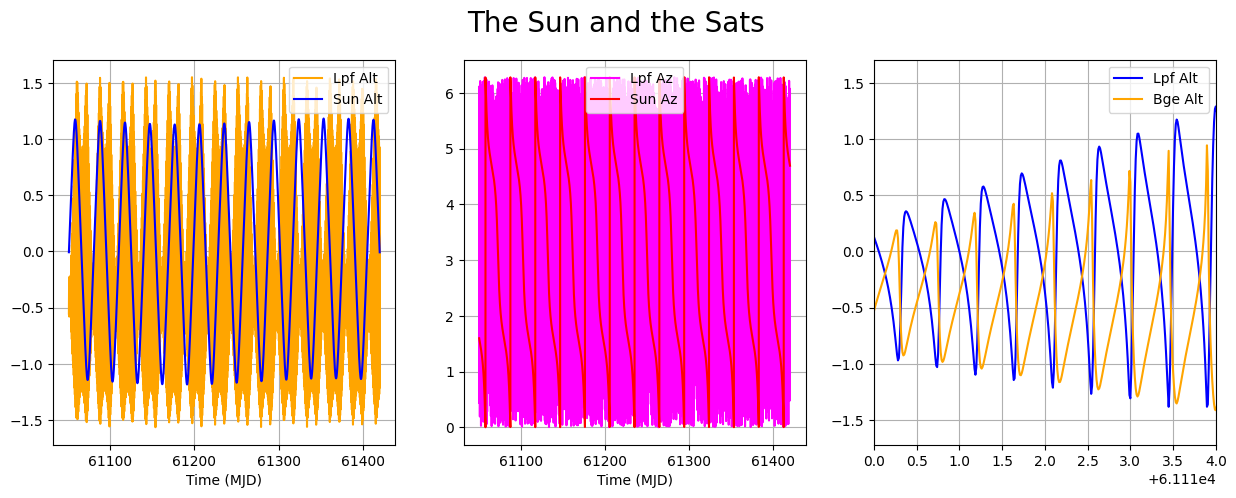

In [6]:
# OPTIONAL PLOTS

plt.rcParams["figure.figsize"] = [15., 5.]

# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
myLpf = smltr.lpf
myBge = smltr.bge

print(mySun.N)

fig, (p1, p2, p3) = plt.subplots(1,3)

fig.suptitle('The Sun and the Sats', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(myLpf.mjd, myLpf.alt,  color="orange", label="Lpf Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(myLpf.mjd, myLpf.az, color="magenta",label="Lpf Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p3.plot(myLpf.mjd, myLpf.alt,  color="blue", label="Lpf Alt")
p3.plot(myBge.mjd, myBge.alt,  color="orange", label="Bge Alt")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()

p3.grid(True)
_ = p3.legend()
p3.set_xlim(61110,61114)

Sunrise: 61331.302083333336


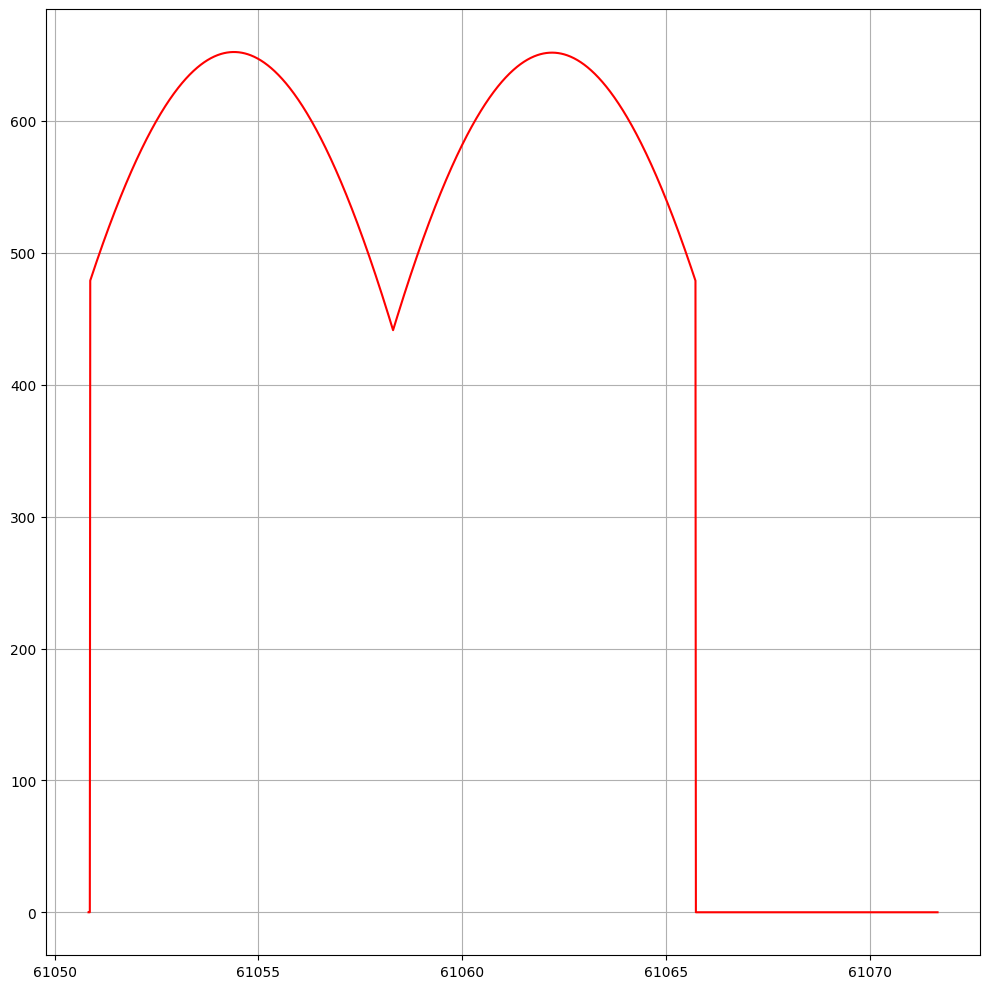

In [7]:
# OPTIONAL

print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd[:2000], smltr.controller.power[:2000],  color="red",    label="Panel power*100")
ax.grid(True)
